# Import libraries and data

In [22]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, f1_score, \
    confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

from utils import keep_first_uniprot
from matplotlib_venn import venn2, venn3

In [6]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature brain data set

In [7]:
df_features = pd.read_csv(data_path + "/Features/df_features_brain_elevated.csv")
df_features

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide,RNA_binding,DNA_binding,Prot_bind,Prot_bind_binary,Ectodomain_shedding,CSF
0,Q6ZMQ8,MSSSFFNPSFAFSSHFDPDGAPLSELSWPSSLAVVAVSFSGLFAVI...,1374,144567.7122,0.105531,0.022562,0.051674,0.088792,0.034934,0.094614,...,0,0,0,0,0,0,0.000000,0,0,-1
1,Q9BZC7,MGFLHQLQLLLWKNVTLKRRSPWVLAFEIFIPLVLFFILLGLRQKK...,2435,269829.6684,0.078850,0.016838,0.043532,0.057084,0.045996,0.069815,...,0,0,0,0,0,0,0.000000,0,0,1
2,Q9NP78,MRLWKAVVVTLAFMSVDICVTTAIYVFSHLDRSLLEDIRHFNIFDS...,766,84473.7976,0.087467,0.010444,0.033943,0.048303,0.050914,0.074413,...,0,0,0,0,0,0,0.014360,1,0,1
3,Q9UBJ2,MTHMLNAAADRVKWTRSSAAKRAACLVAAAYALKTLYPIIGKRLKQ...,740,83231.8369,0.085135,0.013514,0.043243,0.060811,0.031081,0.062162,...,0,0,0,0,0,0,0.006757,1,0,-1
4,Q7Z5M8,MDAQDCQAAASPEPPGPPARSCVAAWWDMVDRNLRYFPHSCSMLGR...,362,40775.8685,0.074586,0.027624,0.058011,0.049724,0.046961,0.063536,...,0,0,0,0,0,0,0.024862,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,Q05996,MACRQRGGSWSPSGWFNAGWSTYRSISLFFALVTSGNSIDVSQLVN...,745,82355.6650,0.059060,0.028188,0.055034,0.046980,0.049664,0.065772,...,0,0,0,0,0,0,0.005369,1,0,1
2538,Q8TCW7,MEQIWLLLLLTIRVLPGSAQFNGYNCDANLHSRFPAERDISVYCGV...,415,45529.4831,0.050602,0.031325,0.045783,0.024096,0.048193,0.067470,...,0,0,0,1,0,0,0.033735,1,0,-1
2539,Q96SZ4,MGPRASLSRLRELCGHWLRPALHTKKQILELLVLEQFLSVLPPHLL...,725,80385.8099,0.074483,0.052414,0.027586,0.073103,0.034483,0.075862,...,1,0,0,0,0,1,0.000000,0,0,-1
2540,Q96LW9,MASTEEQYDLKIVKVEEDPIWDQETHLRGNNFSGQEASRQLFRQFC...,406,47292.5570,0.039409,0.041872,0.029557,0.133005,0.032020,0.054187,...,1,0,0,0,0,1,0.002463,1,0,-1


## CSF data set

In [8]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

## Brain proteome (HPA)

In [9]:
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")

In [10]:
# create data subsets based on tissue specificity
# tissue enhanced + group enriched + tissue enriched
brain_tissue_enhanced = set(brain_elevated["Uniprot"])
# group enriched + tissue enriched
brain_group_enriched = set(brain_elevated[brain_elevated["RNA tissue specificity"].isin(["Group enriched", 
    "Tissue enriched"])]["Uniprot"])
# tissue enriched
brain_tissue_enriched = set(brain_elevated[brain_elevated["RNA tissue specificity"] == "Tissue enriched"]["Uniprot"])

In [11]:
# create data subsets based on tissue distribution
# detected in all + many + some + single
brain_all = set(brain_elevated["Uniprot"])
# detected in many + some + single
brain_many = set(brain_elevated[brain_elevated["RNA tissue distribution"].isin(["Detected in many", "Detected in some",
    "Detected in single"])]["Uniprot"])
# detected in some + single
brain_some = set(brain_elevated[brain_elevated["RNA tissue distribution"].isin(["Detected in some", 
    "Detected in single"])]["Uniprot"])
# detected in single
brain_single = set(brain_elevated[brain_elevated["RNA tissue distribution"] == "Detected in single"]["Uniprot"])

# Machine Learning

In [13]:
# define variables and target
X = (df_features.drop(["Uniprot", "Sequence", "CSF"], axis=1))
y = (df_features["CSF"])

In [14]:
X.columns

Index(['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
       'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'Isoelectric point', 'Instability index', 'Polar', 'Neutral',
       'Hydrophobic', 'Volume_small', 'Volume_medium', 'Volume_large',
       'Polarity_low', 'Polarity_medium', 'Polarity_large',
       'Polarizability_low', 'Polarizability_medium', 'Polarizability_large',
       'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried',
       'Exposed', 'Intermediate', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP',
       'Sheet_NSP', 'Solubility', 'ExpAA', 'First60ExpAA', 'PredHel',
       'PredHel_binary', 'Cytoplasm', 'Extracellular', 'Lysosome/Vacuole',
       'Nucleus', 'Cell_membrane', 'Endoplasmic_reticulum', 'Mitochondrion',
       'Golgi_apparatus', 'Peroxisome', 'Plastid', 'PS00232', 'PS00237',
       'PS00027', 'PS00028', 'PS00022', 'PS01186', 'Glycosylation',
       'GlycoMine_N', 'GlycoMine_O', 'GlycoMine_C', 'GPI-anchor',
 

In [15]:
# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 
        'Volume_medium', 'Volume_large', 'Polarity_low', 'Polarity_medium', 'Polarity_large', 'Polarizability_low', 
        'Polarizability_medium', 'Polarizability_large', 'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried',
        'Exposed', 'Intermediate', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA', 
        'First60ExpAA', 'PredHel', 'Glycosylation', 'Prot_bind']

## Model selection

Linear SVC
- penalty {‘l1’, ‘l2’}, default=’l2’: Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.

- dual bool, default=True: Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.

- C float, default=1.0: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.

- max_iterint, default=1000: The maximum number of iterations to be run.

Logistic Regression
- solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’: Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:
    - For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
    - For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
    - ‘liblinear’ is limited to one-versus-rest schemes.

Warning The choice of the algorithm depends on the penalty chosen: Supported penalties by solver:
- ‘newton-cg’ - [‘l2’, ‘none’]
- ‘lbfgs’ - [‘l2’, ‘none’]
- ‘liblinear’ - [‘l1’, ‘l2’]
- ‘sag’ - [‘l2’, ‘none’]
- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

In [16]:
def scale_data(X_train, X_test, scaler=StandardScaler(), scaled=cont):
    """
    Default is Standard Scaler (standardization) on all variables.
    """
    
    if scaled == "all":
        # scale all variables
        X_train_scal = scaler.fit_transform(X_train)
        X_test_scal = scaler.transform(X_test)

    else:
        # scale continuous variables
        X_train_scal = X_train.copy()
        X_train_scal[scaled] = scaler.fit_transform(X_train_scal[scaled])
        X_test_scal = X_test.copy()
        X_test_scal[scaled] = scaler.transform(X_test_scal[scaled])

    return X_train_scal, X_test_scal, scaler


def preprocess(X, y, random_state=0):
    
    # preprocessing 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)  
    X_train_scal, X_test_scal, scaler = scale_data(X_train, X_test, scaler=StandardScaler(), scaled=cont)
    X_train_bal, y_train_bal = RandomUnderSampler(random_state=0).fit_resample(X_train_scal, y_train)
    
    return X_train_bal, X_test_scal, y_train_bal, y_test, scaler

In [17]:
def model_selection(model, X, y, n=5, scaler=StandardScaler(), scaled="all"):
    """
    """
    # create empty list to save performance measurements
    bac = []
    f1 = []
    auc = []

    for i in range(n):
        
        X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y, random_state=i)
        
        # fit classifier to training data
        model.fit(X_train_bal, y_train_bal)
        # predict on test set
        y_pred = model.predict(X_test_scal) 
        
        # measure performance of model
        bac.append(balanced_accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        try:
            auc.append(roc_auc_score(y_test, model.predict_proba(X_test_scal)[:, 1]))
        except:
            auc.append(roc_auc_score(y_test, model.decision_function(X_test_scal)))

        
    print("Balanced accuracy: %.4f" % np.mean(bac))
    print("F1-score: %.4f" % np.mean(f1))
    print("AUC: %.4f" % np.mean(auc))
    
    return bac, f1, auc

In [18]:
# train the model
models = [RandomForestClassifier(n_estimators=100, random_state=0),
         LinearSVC(C=0.1, max_iter=1000, dual=False, random_state=0),
         LogisticRegression(max_iter=1000, dual=False, random_state=0)]

baclist = []
f1list = []
auclist = []

for model in models:
    print(model)
    bac, f1, auc = model_selection(model, X, y, n=10, scaler=StandardScaler(), scaled=cont)
    baclist.append(bac)
    f1list.append(f1)
    auclist.append(auc)
    print("--------------")

RandomForestClassifier(random_state=0)
Balanced accuracy: 0.7434
F1-score: 0.6918
AUC: 0.8290
--------------
LinearSVC(C=0.1, dual=False, random_state=0)
Balanced accuracy: 0.7411
F1-score: 0.6912
AUC: 0.8190
--------------
LogisticRegression(max_iter=1000, random_state=0)
Balanced accuracy: 0.7408
F1-score: 0.6912
AUC: 0.8187
--------------


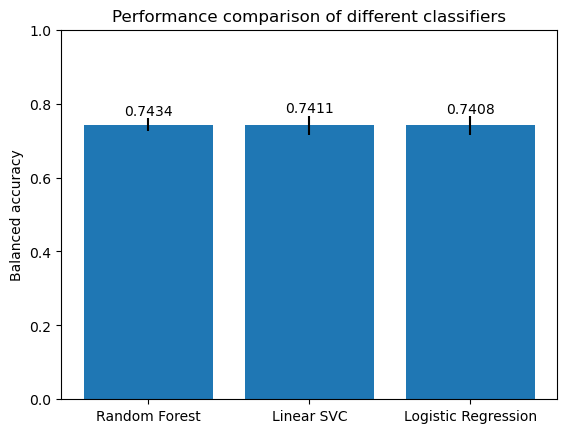

In [19]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in baclist], 
              yerr=[np.std(i) for i in baclist])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="Balanced accuracy", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_BAC.png", bbox_inches="tight")

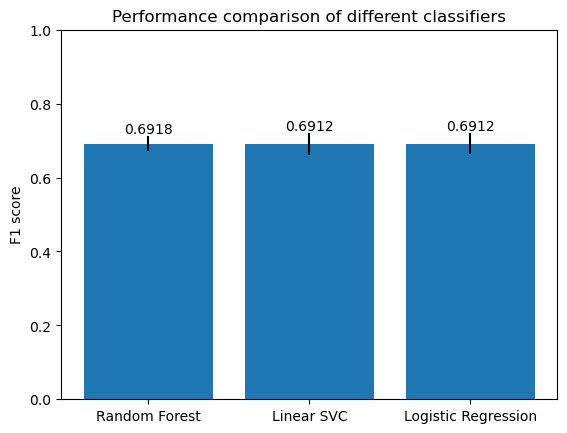

In [20]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in f1list], 
    yerr=[np.std(i) for i in f1list])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="F1 score", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_F1.png", bbox_inches="tight")

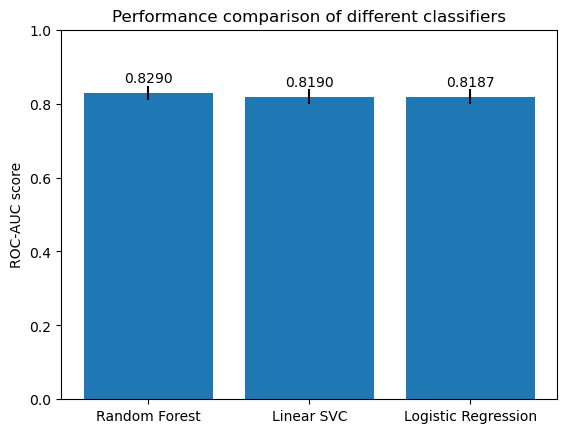

In [21]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in auclist], 
    yerr=[np.std(i) for i in auclist])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="ROC-AUC score", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_AUC.png", bbox_inches="tight")

## Hyperparameter tuning

In [17]:
# preprocessing data 
X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y)

In [23]:
# save the scaler
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "wb") as f:  
    pickle.dump(scaler, f)

### Linear SVC (L2 regularization)

In [24]:
parameters = {"C":[0.01, 0.1, 0.25, 0.5, 0.75, 1, 10]}
svc_l2 = LinearSVC(penalty="l2", dual=False, random_state=0)
grs_svc_l2 = GridSearchCV(svc_l2, parameters, cv=10)
grs_svc_l2.fit(X_train_bal, y_train_bal)

grid_results_svc_l2 = pd.DataFrame(grs_svc_l2.cv_results_).sort_values("param_C")
grid_results_svc_l2.sort_values("rank_test_score")

# small differences between C-values, optimum between 0.1 and 1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021277,0.003253,0.002803,0.000349,0.01,{'C': 0.01},0.74375,0.70000,0.779874,0.735849,0.773585,0.735849,0.748428,0.723270,0.748428,0.767296,0.745633,0.022839,1
1,0.029476,0.005154,0.002966,0.001293,0.1,{'C': 0.1},0.73125,0.68750,0.767296,0.761006,0.773585,0.729560,0.748428,0.729560,0.735849,0.767296,0.743133,0.024699,2
3,0.036011,0.006662,0.002449,0.000961,0.5,{'C': 0.5},0.72500,0.68125,0.754717,0.754717,0.761006,0.748428,0.748428,0.735849,0.735849,0.767296,0.741254,0.023360,3
2,0.030816,0.008057,0.002512,0.001125,0.25,{'C': 0.25},0.72500,0.68125,0.754717,0.754717,0.761006,0.742138,0.748428,0.729560,0.735849,0.773585,0.740625,0.024242,4
5,0.045636,0.009274,0.002240,0.000577,1,{'C': 1},0.72500,0.68125,0.754717,0.754717,0.761006,0.754717,0.742138,0.723270,0.735849,0.767296,0.739996,0.024113,5
4,0.040542,0.008957,0.002205,0.000727,0.75,{'C': 0.75},0.72500,0.68125,0.754717,0.754717,0.761006,0.748428,0.742138,0.723270,0.735849,0.767296,0.739367,0.023801,6
6,0.055715,0.008013,0.002950,0.000561,10,{'C': 10},0.72500,0.68750,0.754717,0.742138,0.761006,0.735849,0.748428,0.729560,0.729560,0.761006,0.737476,0.020803,7


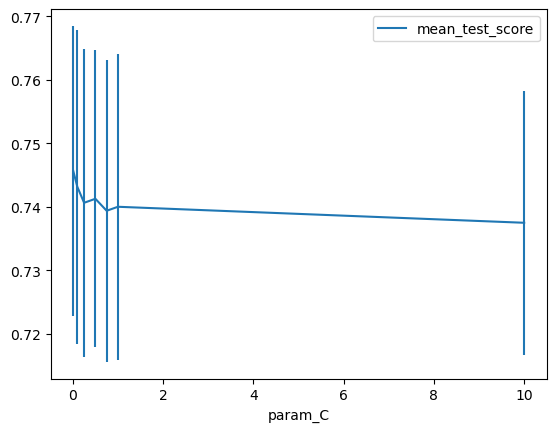

In [25]:
grid_results_svc_l2.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Linear SVC (L1 regularization)

In [26]:
parameters = {"C":[0.01, 0.1, 0.25, 0.5, 0.75, 1]}
svc_l1 = LinearSVC(penalty="l1", max_iter=10000, dual=False, random_state=0)
grs_svc_l1 = GridSearchCV(svc_l1, parameters, cv=10)
grs_svc_l1.fit(X_train_bal, y_train_bal)

grid_results_svc_l1 = pd.DataFrame(grs_svc_l1.cv_results_).sort_values("param_C")
grid_results_svc_l1.sort_values("rank_test_score")

# optimal C value between 0.5 and 1
# for C = 10 convergence warning

C:\Users\kathi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.137062,0.089263,0.002356,0.000644,0.1,{'C': 0.1},0.74375,0.69375,0.767296,0.761006,0.773585,0.729560,0.754717,0.729560,0.735849,0.773585,0.746266,0.023779,1
5,2.893392,1.631826,0.008694,0.007073,1,{'C': 1},0.72500,0.68750,0.761006,0.754717,0.767296,0.748428,0.742138,0.723270,0.735849,0.773585,0.741879,0.024186,2
3,0.460878,0.116941,0.002944,0.001198,0.5,{'C': 0.5},0.73125,0.68750,0.767296,0.761006,0.767296,0.723270,0.735849,0.735849,0.735849,0.773585,0.741875,0.024877,3
4,1.153890,0.487848,0.002989,0.001160,0.75,{'C': 0.75},0.72500,0.68125,0.761006,0.754717,0.767296,0.742138,0.742138,0.723270,0.735849,0.773585,0.740625,0.025514,4
2,0.234697,0.087494,0.007420,0.013111,0.25,{'C': 0.25},0.73125,0.68125,0.767296,0.748428,0.767296,0.723270,0.729560,0.742138,0.735849,0.773585,0.739992,0.025745,5
0,0.028630,0.017116,0.002417,0.000780,0.01,{'C': 0.01},0.68750,0.70625,0.773585,0.698113,0.742138,0.685535,0.761006,0.723270,0.767296,0.761006,0.730570,0.032813,6


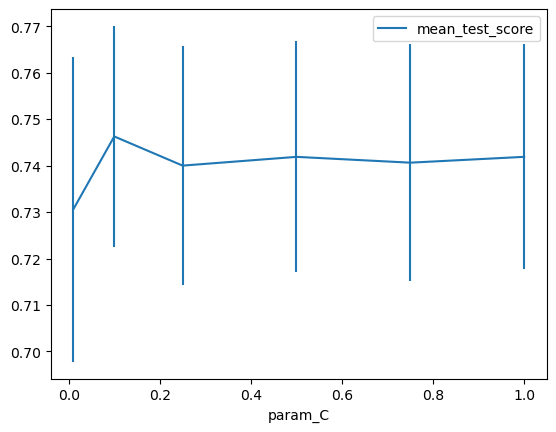

In [27]:
grid_results_svc_l1.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Logistic Regression (L2 regularization)

In [28]:
parameters = {"C":[0.01, 0.1, 0.5, 1, 2.5, 5, 10]}
lr_l2 = LogisticRegression(penalty="l2", max_iter=1000, dual=False, random_state=0)
grs_lr_l2 = GridSearchCV(lr_l2, parameters, cv=10, scoring="balanced_accuracy")
grs_lr_l2.fit(X_train_bal, y_train_bal)

grid_results_lr_l2 = pd.DataFrame(grs_lr_l2.cv_results_).sort_values("param_C")
grid_results_lr_l2.sort_values("rank_test_score")

# different solvers do not influence the accuracy, tested: "solver":["newton-cg", "lbfgs", "saga"]
# no significant difference for C between 1 and 5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.102751,0.019133,0.010236,0.002022,0.1,{'C': 0.1},0.73750,0.68750,0.754430,0.742009,0.780142,0.710759,0.748180,0.716851,0.748813,0.780459,0.740665,0.027846,1
3,0.378632,0.393176,0.009774,0.001452,1,{'C': 1},0.72500,0.68125,0.748180,0.754668,0.773892,0.742247,0.748180,0.735601,0.729826,0.767722,0.740657,0.024630,2
4,0.821661,0.574004,0.014876,0.003742,2.5,{'C': 2.5},0.72500,0.68125,0.748180,0.742089,0.767563,0.748497,0.748180,0.723101,0.729826,0.767722,0.738141,0.024020,3
5,0.453726,0.142998,0.010916,0.002157,5,{'C': 5},0.72500,0.68125,0.748180,0.748339,0.761234,0.748497,0.748180,0.729351,0.723497,0.761392,0.737492,0.022767,4
2,0.158156,0.031141,0.011637,0.005305,0.5,{'C': 0.5},0.73125,0.68125,0.735522,0.742089,0.780222,0.723497,0.748180,0.716851,0.729826,0.780380,0.736907,0.027720,5
6,0.391233,0.047602,0.008725,0.002177,10,{'C': 10},0.73125,0.68125,0.748180,0.748339,0.761234,0.742247,0.748180,0.710522,0.723497,0.761392,0.735609,0.023651,6
0,0.058650,0.009798,0.011407,0.002510,0.01,{'C': 0.01},0.70625,0.68125,0.723101,0.723022,0.735997,0.710522,0.767089,0.723180,0.730063,0.748972,0.724945,0.022313,7


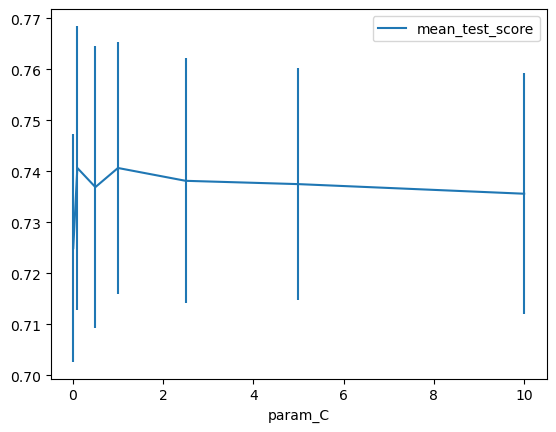

In [29]:
grid_results_lr_l2.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Logistic Regression (L1 regularization)

In [30]:
parameters = {"C":[0.1, 0.5, 1, 2.5, 5, 7.5, 10]}
lr_l1 = LogisticRegression(penalty="l1", solver="saga", max_iter=10000, dual=False, random_state=0)
grs_lr_l1 = GridSearchCV(lr_l1, parameters, cv=10, scoring="balanced_accuracy")
grs_lr_l1.fit(X_train_bal, y_train_bal)

grid_results_lr_l1 = pd.DataFrame(grs_lr_l1.cv_results_).sort_values("param_C")
grid_results_lr_l1.sort_values("rank_test_score")

# liblinear much faster than saga
# saga outperforms liblinear for high C values (>=5)
# liblinear outperforms saga for lower C values (0.1, 1)
# higher C values outperform lower C values (optimum at C=5 for both solvers)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.582083,0.225322,0.004298,0.001275,0.1,{'C': 0.1},0.72500,0.70000,0.779668,0.760759,0.761234,0.723259,0.760680,0.729430,0.761392,0.761472,0.746290,0.023713,1
1,1.551670,0.351134,0.002994,0.001096,0.5,{'C': 0.5},0.73750,0.70000,0.766930,0.742009,0.780222,0.723418,0.748101,0.723022,0.748734,0.780380,0.745032,0.024568,2
2,2.563746,0.407156,0.003284,0.001002,1,{'C': 1},0.71875,0.68750,0.760601,0.748418,0.773892,0.723497,0.741851,0.741851,0.736155,0.780380,0.741290,0.025999,3
4,8.827287,3.295533,0.004666,0.002387,5,{'C': 5},0.73125,0.68125,0.760680,0.748339,0.767563,0.748497,0.748180,0.716772,0.729826,0.767722,0.740008,0.025171,4
5,12.444293,6.186270,0.005175,0.003509,7.5,{'C': 7.5},0.73125,0.68125,0.754430,0.748339,0.761234,0.748497,0.748180,0.716772,0.729826,0.767722,0.738750,0.024066,5
3,2.750281,0.699400,0.003325,0.000911,2.5,{'C': 2.5},0.72500,0.68125,0.754430,0.742089,0.767563,0.735997,0.748180,0.729272,0.729826,0.767722,0.738133,0.023841,6
6,11.907661,3.236130,0.004746,0.002043,10,{'C': 10},0.73125,0.68125,0.754430,0.748339,0.754905,0.742247,0.754509,0.716772,0.729826,0.767722,0.738125,0.023707,7


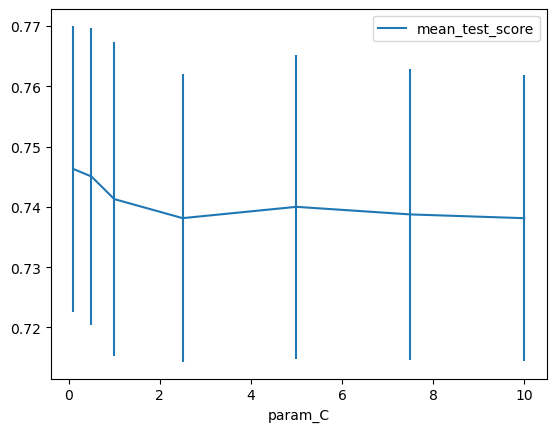

In [31]:
grid_results_lr_l1.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

## Final models & feature importance

### Random Forest

In [92]:
# train RF
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_rf = rf.predict(X_test_scal)
y_score_rf = rf.predict_proba(X_test_scal)

In [93]:
coef_rf = pd.Series(index=X_train_bal.columns, data=rf.feature_importances_, name="RF")
print("Number of features used:", len(coef_rf[coef_rf != 0]))
coef_rf.sort_values(ascending=False, key=abs)[:20]

Number of features used: 78


Signal peptide       0.038803
Sheet_NSP            0.029843
Helix_NSP            0.029139
Length               0.028584
Molecular weight     0.027454
Isoelectric point    0.026370
Solubility           0.025858
D                    0.025132
Nucleus              0.025015
Hydrophobic          0.023264
ExpAA                0.022648
C                    0.022304
Instability index    0.021758
Polarity_low         0.021035
L                    0.020899
H                    0.020069
Exposed              0.019626
G                    0.018272
Charge_negative      0.016952
F                    0.016952
Name: RF, dtype: float64

### Linear SVC

In [94]:
# train SVC , penalty = l2
svc_l2 = LinearSVC(C=0.25, max_iter=10000, dual=False, random_state=0)
svc_l2.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_svc_l2 = svc_l2.predict(X_test_scal)
y_score_svc_l2 = svc_l2.decision_function(X_test_scal)

In [95]:
coef_svc_l2 = pd.Series(index=X_train_bal.columns, data=svc_l2.coef_[0], name="SVC_L2")
print("Number of features used:", len(coef_svc_l2[coef_svc_l2 != 0]))
coef_svc_l2.sort_values(ascending=False, key=abs)[:20]

Number of features used: 78


Nucleus               -0.517507
Golgi_apparatus        0.512426
Signal peptide         0.509158
PS01186                0.445256
Length                 0.430061
PS00028               -0.416303
PS00022                0.400458
Plastid               -0.388672
Ectodomain_shedding    0.319337
PredHel_binary         0.307094
Molecular weight      -0.261667
DNA_binding           -0.222334
PS00237               -0.215492
GlycoMine_C            0.203239
PS00027               -0.196519
Extracellular          0.189474
GPI-anchor             0.178459
Lysosome/Vacuole       0.176246
RNA_binding           -0.167532
GlycoMine_O            0.163504
Name: SVC_L2, dtype: float64

In [96]:
# train SVC , penalty = l1
svc_l1 = LinearSVC(penalty="l1", C=0.75, max_iter=10000, dual=False, random_state=0)
svc_l1.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_svc_l1 = svc_l1.predict(X_test_scal)
y_score_svc_l1 = svc_l1.decision_function(X_test_scal)

In [97]:
coef_svc_l1 = pd.Series(index=X_train_bal.columns, data=svc_l1.coef_[0], name="SVC_L1")
print("Number of features used:", len(coef_svc_l1[coef_svc_l1 != 0]))
coef_svc_l1[coef_svc_l1 != 0].sort_values(ascending=False, key=abs)[:20]

Number of features used: 54


Golgi_apparatus        0.531693
Signal peptide         0.518709
Nucleus               -0.510173
PS01186                0.508068
Length                 0.501015
PS00028               -0.431458
PS00022                0.406915
Plastid               -0.391058
Molecular weight      -0.332564
Ectodomain_shedding    0.317454
PredHel_binary         0.299773
Polarity_low          -0.249729
DNA_binding           -0.218102
PS00237               -0.207651
Extracellular          0.193907
PS00027               -0.177437
GlycoMine_C            0.176644
GPI-anchor             0.168784
RNA_binding           -0.161199
GlycoMine_O            0.160874
Name: SVC_L1, dtype: float64

In [98]:
coef_svc_l1[coef_svc_l1 == 0]

I                        0.0
P                        0.0
R                        0.0
T                        0.0
Y                        0.0
Polar                    0.0
Neutral                  0.0
Hydrophobic              0.0
Volume_small             0.0
Volume_medium            0.0
Volume_large             0.0
Polarity_medium          0.0
Polarity_large           0.0
Polarizability_large     0.0
Charge_neutral           0.0
Charge_negative          0.0
Buried                   0.0
Exposed                  0.0
Intermediate             0.0
Helix_NSP                0.0
Endoplasmic_reticulum    0.0
Mitochondrion            0.0
Peroxisome               0.0
PS00232                  0.0
Name: SVC_L1, dtype: float64

### Logistic Regression

In [99]:
# train logistic classifier, penalty = l2
lr_l2 = LogisticRegression(penalty="l2", C=2.5, max_iter=1000, dual=False, random_state=0)
lr_l2.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_lr_l2 = lr_l2.predict(X_test_scal)
y_score_lr_l2 = lr_l2.decision_function(X_test_scal)

In [100]:
# save the model 
with open(os.getcwd() + "/Models/LogisticClassifier_L2.pkl", "wb") as f:  
    pickle.dump(lr_l2, f)

In [101]:
coef_lr_l2 = pd.Series(index=X_train_bal.columns, data=lr_l2.coef_[0], name="LR_L2")
print("Number of features used:", len(coef_lr_l2[coef_lr_l2 != 0]))
coef_lr_l2.sort_values(ascending=False, key=abs)[:20]

Number of features used: 78


PS01186                1.474914
PS00028               -1.421271
Signal peptide         1.408433
Golgi_apparatus        1.374039
PS00022                1.245731
Nucleus               -1.223015
Length                 1.127345
Ectodomain_shedding    0.905062
Plastid               -0.901634
PredHel_binary         0.849977
PS00027               -0.721178
DNA_binding           -0.690584
Molecular weight      -0.671779
GlycoMine_C            0.612890
PS00237               -0.586945
Extracellular          0.582927
PS00232                0.506744
GPI-anchor             0.505269
RNA_binding           -0.478930
Lysosome/Vacuole       0.476185
Name: LR_L2, dtype: float64

In [102]:
# train logistic classifier, penalty = l1
lr_l1 = LogisticRegression(penalty="l1", solver="saga", C=5, max_iter=10000, dual=False, random_state=0)
lr_l1.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_lr_l1 = lr_l1.predict(X_test_scal)
y_score_lr_l1 = lr_l1.decision_function(X_test_scal)

In [103]:
coef_lr_l1 = pd.Series(index=X_train_bal.columns, data=lr_l1.coef_[0], name="LR_L1")
print("Number of features used:", len(coef_lr_l1[coef_lr_l1 != 0]))
coef_lr_l1.sort_values(ascending=False, key=abs)[:20]

Number of features used: 60


PS01186                2.503603
Length                 2.313778
Molecular weight      -1.854956
PS00028               -1.739317
Signal peptide         1.420496
Golgi_apparatus        1.415222
PS00022                1.395993
Nucleus               -1.228277
Plastid               -1.049533
Ectodomain_shedding    0.927217
PredHel_binary         0.853005
PS00027               -0.775022
DNA_binding           -0.674042
GlycoMine_C            0.649435
PS00237               -0.606317
Extracellular          0.583220
GPI-anchor             0.520186
PS00232                0.518165
RNA_binding           -0.484214
Polarity_low          -0.461671
Name: LR_L1, dtype: float64

In [104]:
coef_lr_l1[coef_lr_l1 == 0]

P                        0.0
R                        0.0
T                        0.0
Polar                    0.0
Neutral                  0.0
Volume_small             0.0
Volume_medium            0.0
Volume_large             0.0
Polarity_medium          0.0
Polarity_large           0.0
Polarizability_large     0.0
Charge_neutral           0.0
Charge_negative          0.0
Buried                   0.0
Exposed                  0.0
Intermediate             0.0
Helix_NSP                0.0
Endoplasmic_reticulum    0.0
Name: LR_L1, dtype: float64

## Model evaluation

In [105]:
models = [rf, svc_l2, svc_l1, lr_l2, lr_l1]
model_names = ["Random Forest", "SVC (L2)", "SVC (L1)", "Logistic Classifier (L2)", "Logistic Classifier (L1)"]

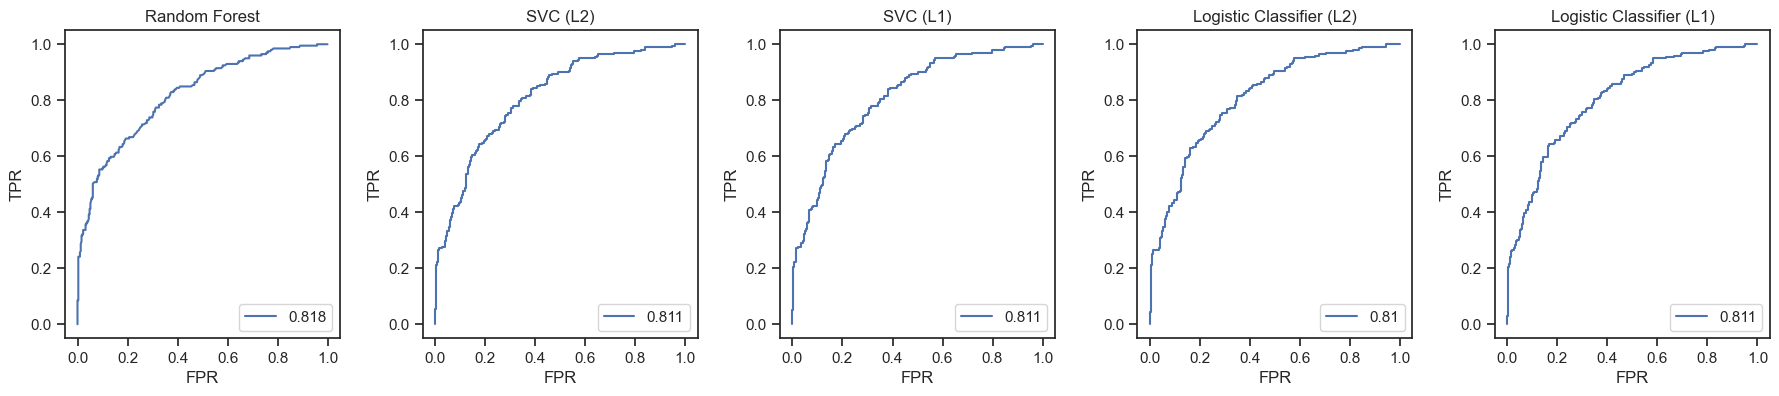

In [108]:
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
fig.subplots_adjust(wspace=0.3)

for i in range(5):
    RocCurveDisplay.from_estimator(models[i], X_test_scal, y_test, ax=ax[i])
    ax[i].set(xlabel="FPR", ylabel="TPR", title=model_names[i])
    try:
        ax[i].legend(labels=[round(roc_auc_score(y_test, models[i].predict_proba(X_test_scal)[:, 1]), 3)], loc="lower right")
    except:
        ax[i].legend(labels=[round(roc_auc_score(y_test, models[i].decision_function(X_test_scal)), 3)], loc="lower right")

plt.show()
fig.savefig(fig_path + "Final_models_AUC_ROC_curve.png", bbox_inches="tight")

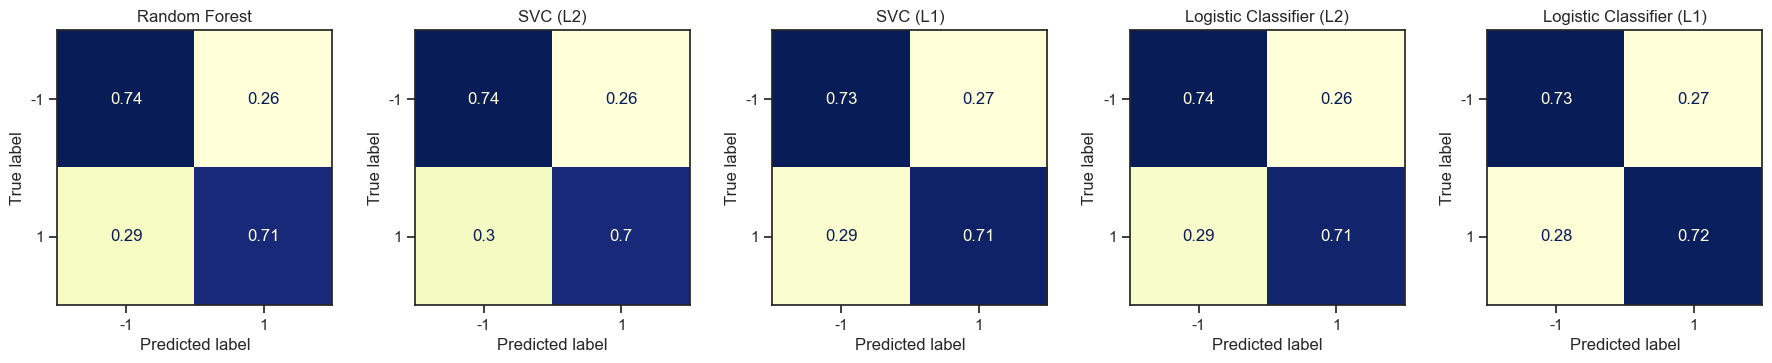

In [109]:
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
fig.subplots_adjust(wspace=0.3)

for i in range(5):
    ConfusionMatrixDisplay.from_estimator(models[i], X_test_scal, y_test, normalize="true", colorbar=False, cmap="YlGnBu", 
        ax=ax[i])
    ax[i].set(title=model_names[i])

plt.show()
fig.savefig(fig_path + "Final_models_confusion_matrix.png", bbox_inches="tight")

In [48]:
# save model
#### TO DO ####

## Feature importance

In [49]:
rank_rf = abs(coef_rf).rank().sort_values()
rank_svc_l2 = abs(coef_svc_l2).rank().sort_values()
rank_svc_l1 = abs(coef_svc_l1[coef_svc_l1 != 0]).rank().sort_values()
rank_lr_l2 = abs(coef_lr_l2).rank().sort_values()
rank_lr_l1 = abs(coef_lr_l1[coef_lr_l1 != 0]).rank().sort_values()

In [50]:
all_ranks = pd.merge(rank_rf, rank_svc_l2, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_svc_l1, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_lr_l2, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_lr_l1, left_index=True, right_index=True, how="outer")
all_ranks.fillna(0, inplace=True)
all_ranks["Mean"] = all_ranks.mean(axis=1)
all_ranks.sort_values("Mean", ascending=False, inplace=True)
all_ranks[:10]

,RF,SVC_L2,SVC_L1,LR_L2,LR_L1,Mean
Signal peptide,77.0,77.0,53.0,76.0,56.0,67.8
Length,74.0,73.0,54.0,71.0,59.0,66.2
Nucleus,70.0,76.0,50.0,72.0,53.0,64.2
Molecular weight,73.0,68.0,49.0,67.0,58.0,63.0
Golgi_apparatus,16.0,75.0,51.0,74.0,54.0,54.0
PS01186,4.0,74.0,52.0,77.0,60.0,53.4
PS00028,8.0,71.0,48.0,75.0,57.0,51.8
PS00022,10.0,72.0,47.0,73.0,55.0,51.4
PredHel_binary,19.0,69.0,45.0,69.0,51.0,50.6
DNA_binding,23.0,66.0,43.0,66.0,48.0,49.2


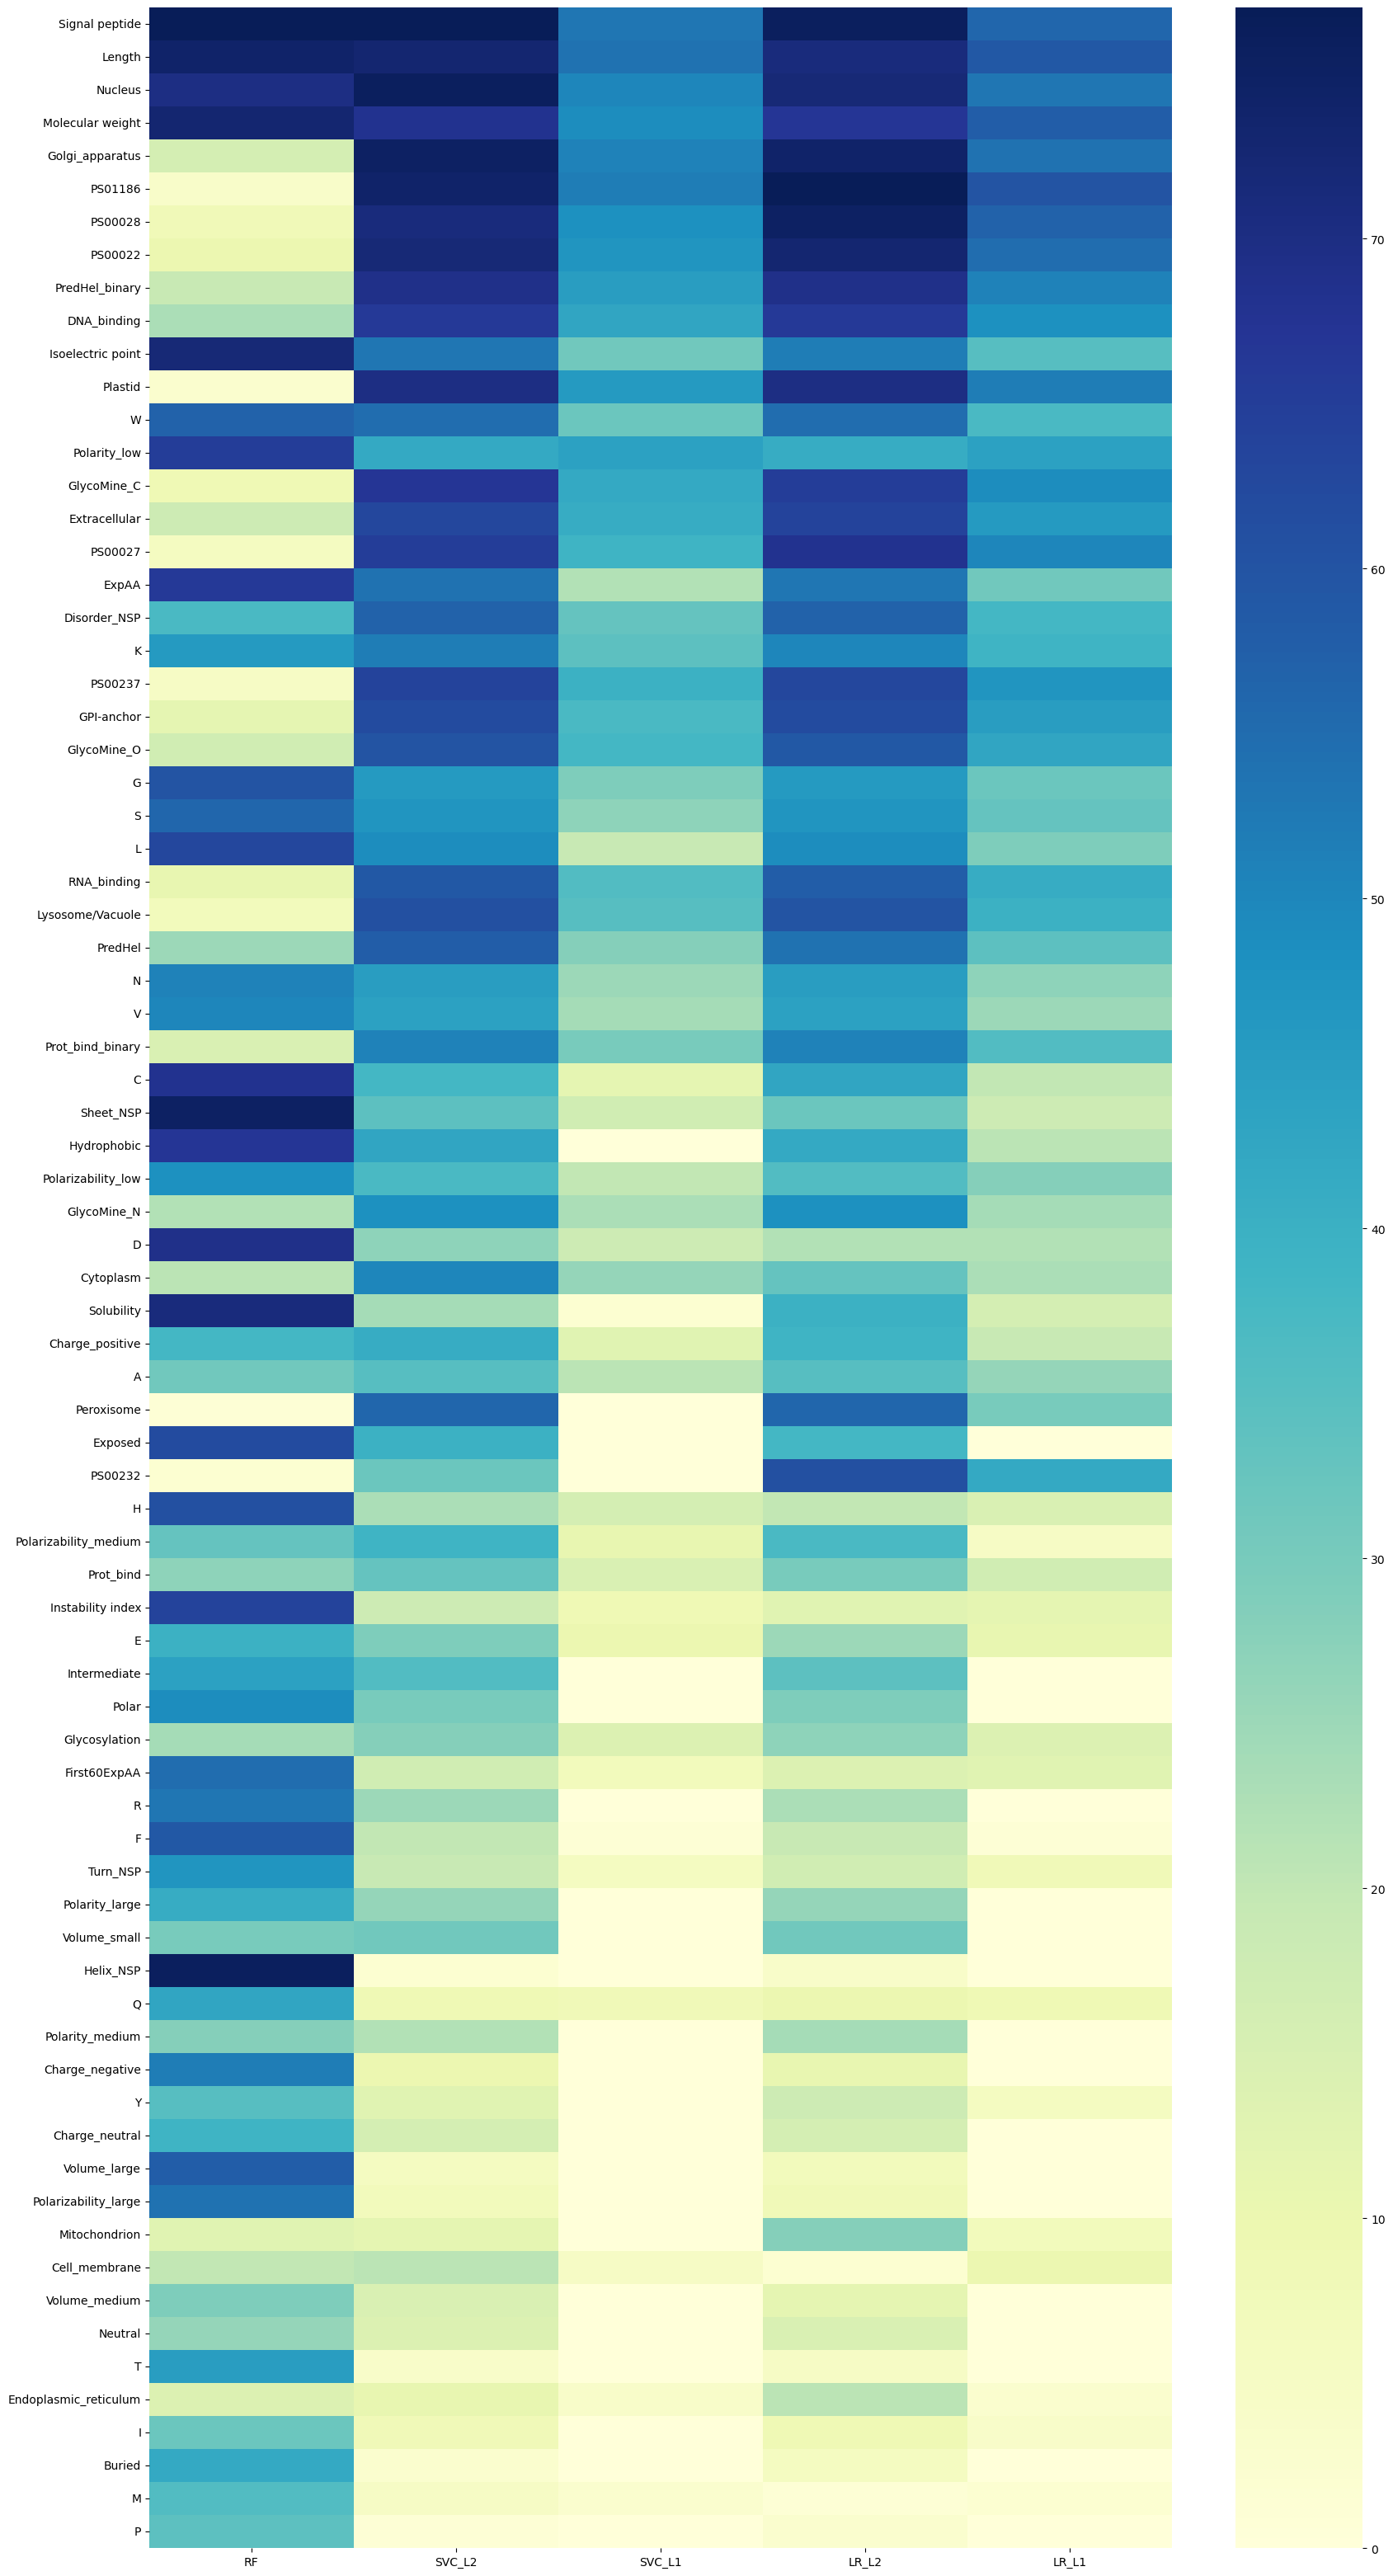

In [51]:
fig = plt.figure(figsize=(20, 40))

sns.heatmap(all_ranks[["RF", "SVC_L2", "SVC_L1", "LR_L2", "LR_L1"]], cmap="YlGnBu")

plt.show()
fig.savefig(fig_path + "Heatmap_feature_ranking.png", bbox_inches="tight")

## Dataset stringency

In [112]:
def increase_stringency_CSF(feature_df, csf_df, i):
    
    stringent_csf = csf_df[csf_df["#Studies"]>=i]["Uniprot"]
    remove_csf = set(df_features[df_features["CSF"] == 1]["Uniprot"]) - set(stringent_csf)
    df_stringent = df_features.drop(df_features[(df_features["CSF"] == 1) & (df_features["Uniprot"].isin(remove_csf))].index)
    
    print("Number of CSF proteins to be removed:", len(remove_csf))
    print("Number of CSF proteins left:", len(df_stringent[(df_stringent["CSF"] == 1)]))   
    
    return df_stringent


def increase_stringency_brain(feature_df, brain_set):

    df_stringent = feature_df[feature_df["Uniprot"].isin(brain_set)]
    print("Number of brain proteins to be removed:", len(df_features) - len(df_stringent))
    print("Number of CSF proteins left:", len(df_stringent[(df_stringent["CSF"] == 1)]))   
    print("Number of non-CSF proteins left:", len(df_stringent[(df_stringent["CSF"] == -1)])) 
    
    return df_stringent


def accuracy_stringent(df, n):
    
    # define explanatory and response variables
    X = (df.drop(["Uniprot", "Sequence", "CSF"], axis=1))
    y = (df["CSF"])
    
    bac = []
    auc = []
    
    for i in range(10):
        
        X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y, random_state=i)
        
        # train model
        lr = LogisticRegression(C=2.5, max_iter=1000, dual=False, random_state=0).fit(X_train_bal, y_train_bal)
        y_pred = lr.predict(X_test_scal)
        
        # print(i, "Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
        bac.append(balanced_accuracy_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, lr.decision_function(X_test_scal)))
        
        if i == 0:
            coef = pd.Series(index=X_train_bal.columns, data=lr.coef_[0], name=n)
            coef.sort_values(ascending=False, key=abs, inplace=True)

    return bac, auc, coef

### CSF proteins

In [113]:
baclist_csf = []
auclist_csf = []
coefs = []

print("Number of non-CSF proteins:", len(df_features[df_features["CSF"] == -1]))

for i in range(1, csf["#Studies"].max()+1):
    print("-------------")
    print("Number of minimum CSF studies:", i)
    df_stringent = increase_stringency_CSF(df_features, csf, i)
    bac, auc, coef = accuracy_stringent(df_stringent, n=i)
    
    baclist_csf.append(bac)
    auclist_csf.append(auc)
    coefs.append(coef)

Number of non-CSF proteins: 1547
-------------
Number of minimum CSF studies: 1
Number of CSF proteins to be removed: 0
Number of CSF proteins left: 995
-------------
Number of minimum CSF studies: 2
Number of CSF proteins to be removed: 303
Number of CSF proteins left: 692
-------------
Number of minimum CSF studies: 3
Number of CSF proteins to be removed: 454
Number of CSF proteins left: 541
-------------
Number of minimum CSF studies: 4
Number of CSF proteins to be removed: 521
Number of CSF proteins left: 474
-------------
Number of minimum CSF studies: 5
Number of CSF proteins to be removed: 588
Number of CSF proteins left: 407
-------------
Number of minimum CSF studies: 6
Number of CSF proteins to be removed: 693
Number of CSF proteins left: 302
-------------
Number of minimum CSF studies: 7
Number of CSF proteins to be removed: 833
Number of CSF proteins left: 162


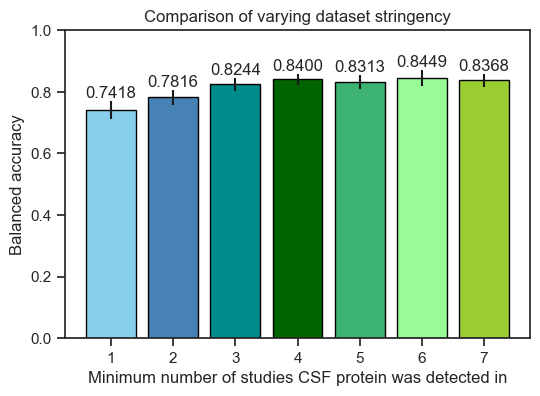

In [114]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

bars = ax.bar(x=[1,2,3,4,5,6,7], height=[np.mean(i) for i in baclist_csf], yerr=[np.std(i) for i in baclist_csf], 
#     color=["darkgreen", "mediumseagreen", "palegreen", "greenyellow", "yellow", "gold", "goldenrod"], edgecolor="black")
#     color=["darkgreen", "mediumseagreen", "palegreen", "aquamarine", "lightseagreen", "teal", "darkslategrey"], edgecolor="black")
#     color=["darkslategrey", "teal", "lightseagreen", "aquamarine", "palegreen", "mediumseagreen", "darkgreen"], edgecolor="black")
    color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"], edgecolor="black")

ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Minimum number of studies CSF protein was detected in", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

# fig.savefig(fig_path + "Increased_dataset_stringency_CSF_BAC.png", bbox_inches="tight")

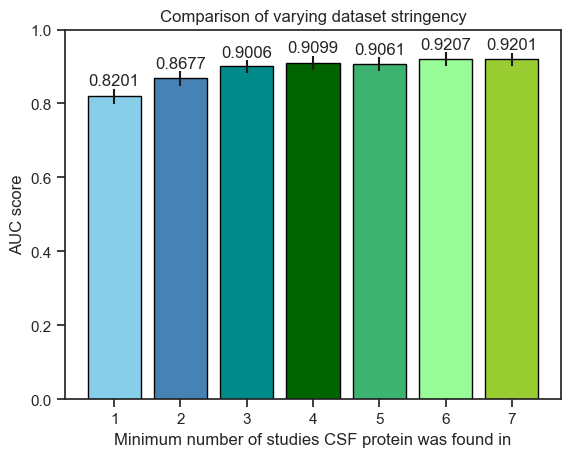

In [115]:
fig, ax = plt.subplots()

bars = ax.bar(x=[1,2,3,4,5,6,7], height=[np.mean(i) for i in auclist_csf], yerr=[np.std(i) for i in auclist_csf],
    color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"], edgecolor="black")
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Minimum number of studies CSF protein was found in", ylabel="AUC score", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

# fig.savefig(fig_path + "Increased_dataset_stringency_CSF_AUC.png", bbox_inches="tight")

## Influence of brain dataset stringency

In [57]:
baclist_brain = []
auclist_brain = []

brain_sets = [brain_tissue_enhanced, brain_group_enriched, brain_tissue_enriched]

print("Number of brain proteins:", len(df_features))

for i in range(len(brain_sets)):
    print("-------------")
    df_stringent = increase_stringency_brain(df_features, brain_sets[i])
    bac, auc, cm = accuracy_stringent(df_stringent, n=i)
    
    baclist_brain.append(bac)
    auclist_brain.append(auc)

Number of brain proteins: 2542
-------------
Number of brain proteins to be removed: 0
Number of CSF proteins left: 995
Number of non-CSF proteins left: 1547
-------------
Number of brain proteins to be removed: 1459
Number of CSF proteins left: 424
Number of non-CSF proteins left: 659
-------------
Number of brain proteins to be removed: 2056
Number of CSF proteins left: 201
Number of non-CSF proteins left: 285


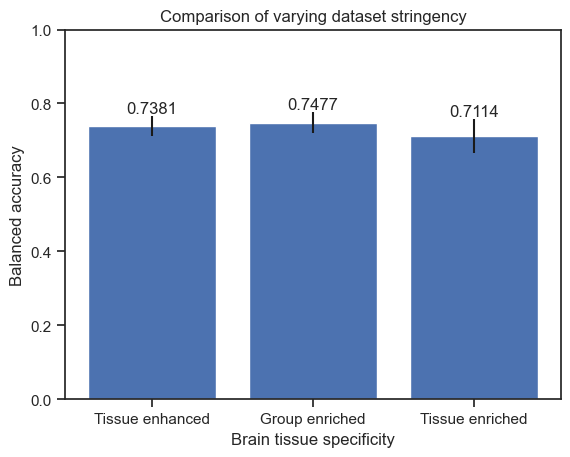

In [58]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Tissue enhanced", "Group enriched", "Tissue enriched"], height=[np.mean(i) for i in baclist_brain], yerr=[np.std(i) for i in baclist_brain])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Brain tissue specificity", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_brain_specifcity_BAC.png", bbox_inches="tight")

In [59]:
baclist_brain = []
auclist_brain = []

brain_sets = [brain_all, brain_many, brain_some, brain_single]

print("Number of brain proteins:", len(df_features))

for i in range(len(brain_sets)):
    print("-------------")
    df_stringent = increase_stringency_brain(df_features, brain_sets[i])
    bac, auc, cm = accuracy_stringent(df_stringent, n=i)
    
    baclist_brain.append(bac)
    auclist_brain.append(auc)

Number of brain proteins: 2542
-------------
Number of brain proteins to be removed: 0
Number of CSF proteins left: 995
Number of non-CSF proteins left: 1547
-------------
Number of brain proteins to be removed: 331
Number of CSF proteins left: 846
Number of non-CSF proteins left: 1365
-------------
Number of brain proteins to be removed: 1382
Number of CSF proteins left: 348
Number of non-CSF proteins left: 812
-------------
Number of brain proteins to be removed: 2377
Number of CSF proteins left: 35
Number of non-CSF proteins left: 130


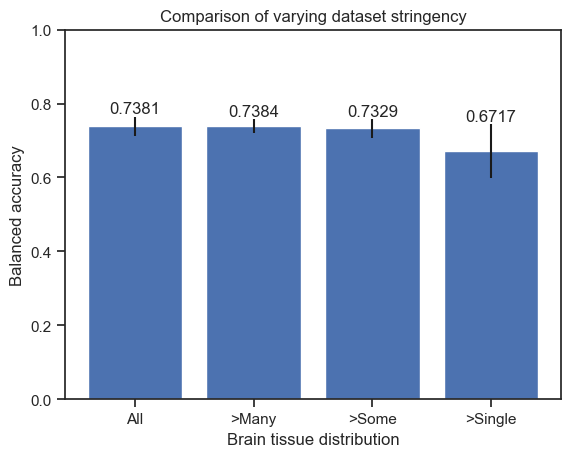

In [60]:
fig, ax = plt.subplots()

bars = ax.bar(x=["All", ">Many", ">Some", ">Single"], height=[np.mean(i) for i in baclist_brain], yerr=[np.std(i) for i in baclist_brain])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Brain tissue distribution", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_brain_distribution_BAC.png", bbox_inches="tight")

## Feature analysis of models trained on more stringent CSF data

In [116]:
def stringent_dataset_analysis(df):
    
    # define explanatory and response variables
    X = (df.drop(["Uniprot", "Sequence", "CSF"], axis=1))
    y = (df["CSF"])
    
    coefs = []
    
    for i in range(10):
        
        # preprocessing 
        X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y, random_state=i)  

        # train model
        lr = LogisticRegression(C=1, max_iter=1000, dual=False, random_state=0).fit(X_train_bal, y_train_bal)
#         rf = RandomForestClassifier(n_estimators=1000, random_state=0).fit(X_train_bal, y_train_bal)
        
        # extract coefficients
        coef = pd.Series(index=X_train_bal.columns, data=lr.coef_[0], name=i)
#         coef = pd.Series(index=X_train_bal.columns, data=rf.feature_importances_, name=i)
        coef.sort_values(ascending=False, key=abs, inplace=True)
        coefs.append(coef)
    
    # merge all coefficient series into oen dataframe
    coefs_df = pd.merge(coefs[0], coefs[1], left_index=True, right_index=True)
    for i in range(2, len(coefs)):
        coefs_df = pd.merge(coefs_df, coefs[i], left_index=True, right_index=True)  
                        
    coefs_df["Mean"] = coefs_df.mean(axis=1)
    coefs_df["Standard deviation"] = coefs_df.std(axis=1)
                        
    return coefs_df

In [117]:
# create more stirngent data sets
df_features_2plus = increase_stringency_CSF(df_features, csf, 2)
print("Number of proteins in dataset:", len(df_features_2plus))
print("-------------")
df_features_3plus = increase_stringency_CSF(df_features, csf, 3)
print("Number of proteins in dataset:", len(df_features_3plus))

Number of CSF proteins to be removed: 303
Number of CSF proteins left: 692
Number of proteins in dataset: 2239
-------------
Number of CSF proteins to be removed: 454
Number of CSF proteins left: 541
Number of proteins in dataset: 2088


In [118]:
coefs_df = stringent_dataset_analysis(df_features)
coefs_df_2plus = stringent_dataset_analysis(df_features_2plus)
coefs_df_3plus = stringent_dataset_analysis(df_features_3plus)

In [119]:
coefs_df.sort_values("Mean", ascending=False, key=abs)[:20]

,0,1,2,3,4,5,6,7,8,9,Mean,Standard deviation
Signal peptide,1.393232,1.402982,1.363101,1.500429,1.395605,1.300700,1.459729,1.176033,1.221423,1.574647,1.378788,0.115327
Golgi_apparatus,1.247392,1.560939,1.311093,1.532715,0.864951,1.591084,1.560330,1.264396,1.287211,1.210582,1.343069,0.213958
Nucleus,-1.233815,-1.300765,-1.265054,-1.492863,-1.060162,-1.297977,-1.331679,-1.299857,-1.199800,-1.220991,-1.270296,0.104301
PS00028,-1.082560,-1.243345,-0.647507,-1.203667,-1.418540,-1.274305,-1.292418,-1.099965,-0.970469,-1.066538,-1.129931,0.203510
PS00022,0.975547,0.740670,1.451907,0.770633,0.519816,0.652750,1.081183,1.139540,0.646608,0.969881,0.894853,0.267794
Ectodomain_shedding,0.820608,0.513574,0.988400,0.549894,0.940065,1.018831,0.906014,1.173989,0.560204,0.695657,0.816724,0.215573
PS00027,-0.565772,-0.731853,-0.812277,-1.119455,-0.603887,-0.896924,-0.927323,-0.627300,-0.967475,-0.693272,-0.794554,0.171681
PS01186,1.007508,0.657088,0.855992,0.543973,0.790799,0.227752,1.042995,0.818810,0.495579,1.089613,0.753011,0.259536
PS00232,0.354693,0.567238,0.291194,0.879256,0.383983,0.959742,0.502870,0.866347,1.029762,0.822251,0.665733,0.261138
Length,0.634432,0.688568,0.686938,0.542457,0.712348,0.607456,0.366386,0.637160,0.679689,0.657199,0.621263,0.096765


In [120]:
coefs_df_2plus.sort_values("Mean", ascending=False, key=abs)[:20]

,0,1,2,3,4,5,6,7,8,9,Mean,Standard deviation
Golgi_apparatus,1.700574,1.620258,1.991972,1.743194,1.532533,1.633856,1.496397,1.541290,1.839510,1.205517,1.630510,0.202046
Nucleus,-1.908297,-1.797759,-1.431937,-1.723276,-1.525476,-1.273124,-1.752098,-1.718724,-1.759644,-1.375286,-1.626562,0.199037
Signal peptide,1.409048,1.738618,1.616303,1.658404,1.802418,1.486166,1.471585,1.216560,1.741233,1.498433,1.563877,0.171469
Ectodomain_shedding,1.571289,0.966732,0.706263,0.777344,1.262718,1.004295,1.817623,1.185361,1.733980,0.850269,1.187588,0.380065
Extracellular,0.916138,1.203271,0.648881,1.005754,0.879179,0.990417,0.952652,0.822327,1.130515,0.785988,0.933512,0.154531
PS00022,0.589441,0.841953,1.303588,0.948649,0.291721,1.088301,0.785087,1.039010,1.133631,0.600061,0.862144,0.288664
Lysosome/Vacuole,-0.675100,-0.669945,-1.069274,-0.633632,-0.520558,-0.996600,-1.085632,-0.485101,-0.756092,-0.466979,-0.735891,0.224036
Peroxisome,-0.632132,-0.586047,-0.606883,-0.579065,-1.026740,-0.929272,-0.588128,-0.310341,-0.753887,-0.618618,-0.663111,0.189863
PS01186,0.444973,0.495006,1.019417,0.887922,0.116109,0.847717,0.459371,0.915386,0.669487,0.730607,0.658599,0.263851
PredHel_binary,0.457575,0.895456,0.729967,0.681674,0.554570,0.795047,0.290535,0.617831,0.767566,0.760269,0.655049,0.170527


In [121]:
coefs_df_3plus.sort_values("Mean", ascending=False, key=abs)[:20]

,0,1,2,3,4,5,6,7,8,9,Mean,Standard deviation
Nucleus,-1.790683,-2.166648,-1.393607,-1.765335,-1.726790,-2.015408,-1.752944,-2.059925,-1.992443,-1.835396,-1.849918,0.208753
Signal peptide,1.732263,1.612433,1.900598,1.356808,1.625825,1.956197,1.760434,1.978917,2.031964,1.835127,1.779057,0.196284
Golgi_apparatus,1.332147,1.351461,1.696516,1.371043,1.603886,2.360671,1.389239,2.132002,1.642272,1.899614,1.677885,0.336486
Ectodomain_shedding,1.582860,1.968656,1.000858,0.889567,1.287165,1.066436,1.465080,1.579598,1.122307,1.393699,1.335623,0.311907
DNA_binding,-0.977945,-1.093654,-1.366500,-1.261531,-1.010092,-0.786265,-0.795492,-0.793696,-1.234277,-1.058446,-1.037790,0.196512
Extracellular,1.063996,1.144701,1.393332,0.996518,0.793024,0.930815,1.053237,0.828215,1.108479,0.822690,1.013501,0.173525
PS00022,0.440494,0.651056,1.002073,1.074001,0.955035,0.634985,1.073300,1.104031,1.022982,0.790361,0.874832,0.218986
PredHel_binary,0.700027,0.826243,1.123773,0.816397,0.550559,1.098403,0.603086,0.626064,0.940535,0.348964,0.763405,0.233638
Lysosome/Vacuole,-0.965936,-0.316741,-1.037237,-0.538258,-0.415657,-0.370776,-0.982005,-0.877221,-0.131783,-0.975998,-0.661161,0.322743
PS01186,0.323279,0.378584,0.591595,0.954188,0.356511,0.274469,1.017206,0.698299,1.191596,0.433197,0.621892,0.311948


## Decision tree

In [18]:
dt = DecisionTreeClassifier()
dt.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier()

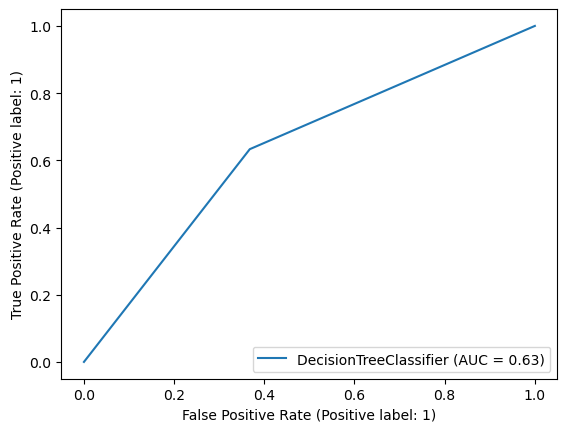

In [29]:
RocCurveDisplay.from_estimator(dt, X_test_scal, y_test)
plt.show()

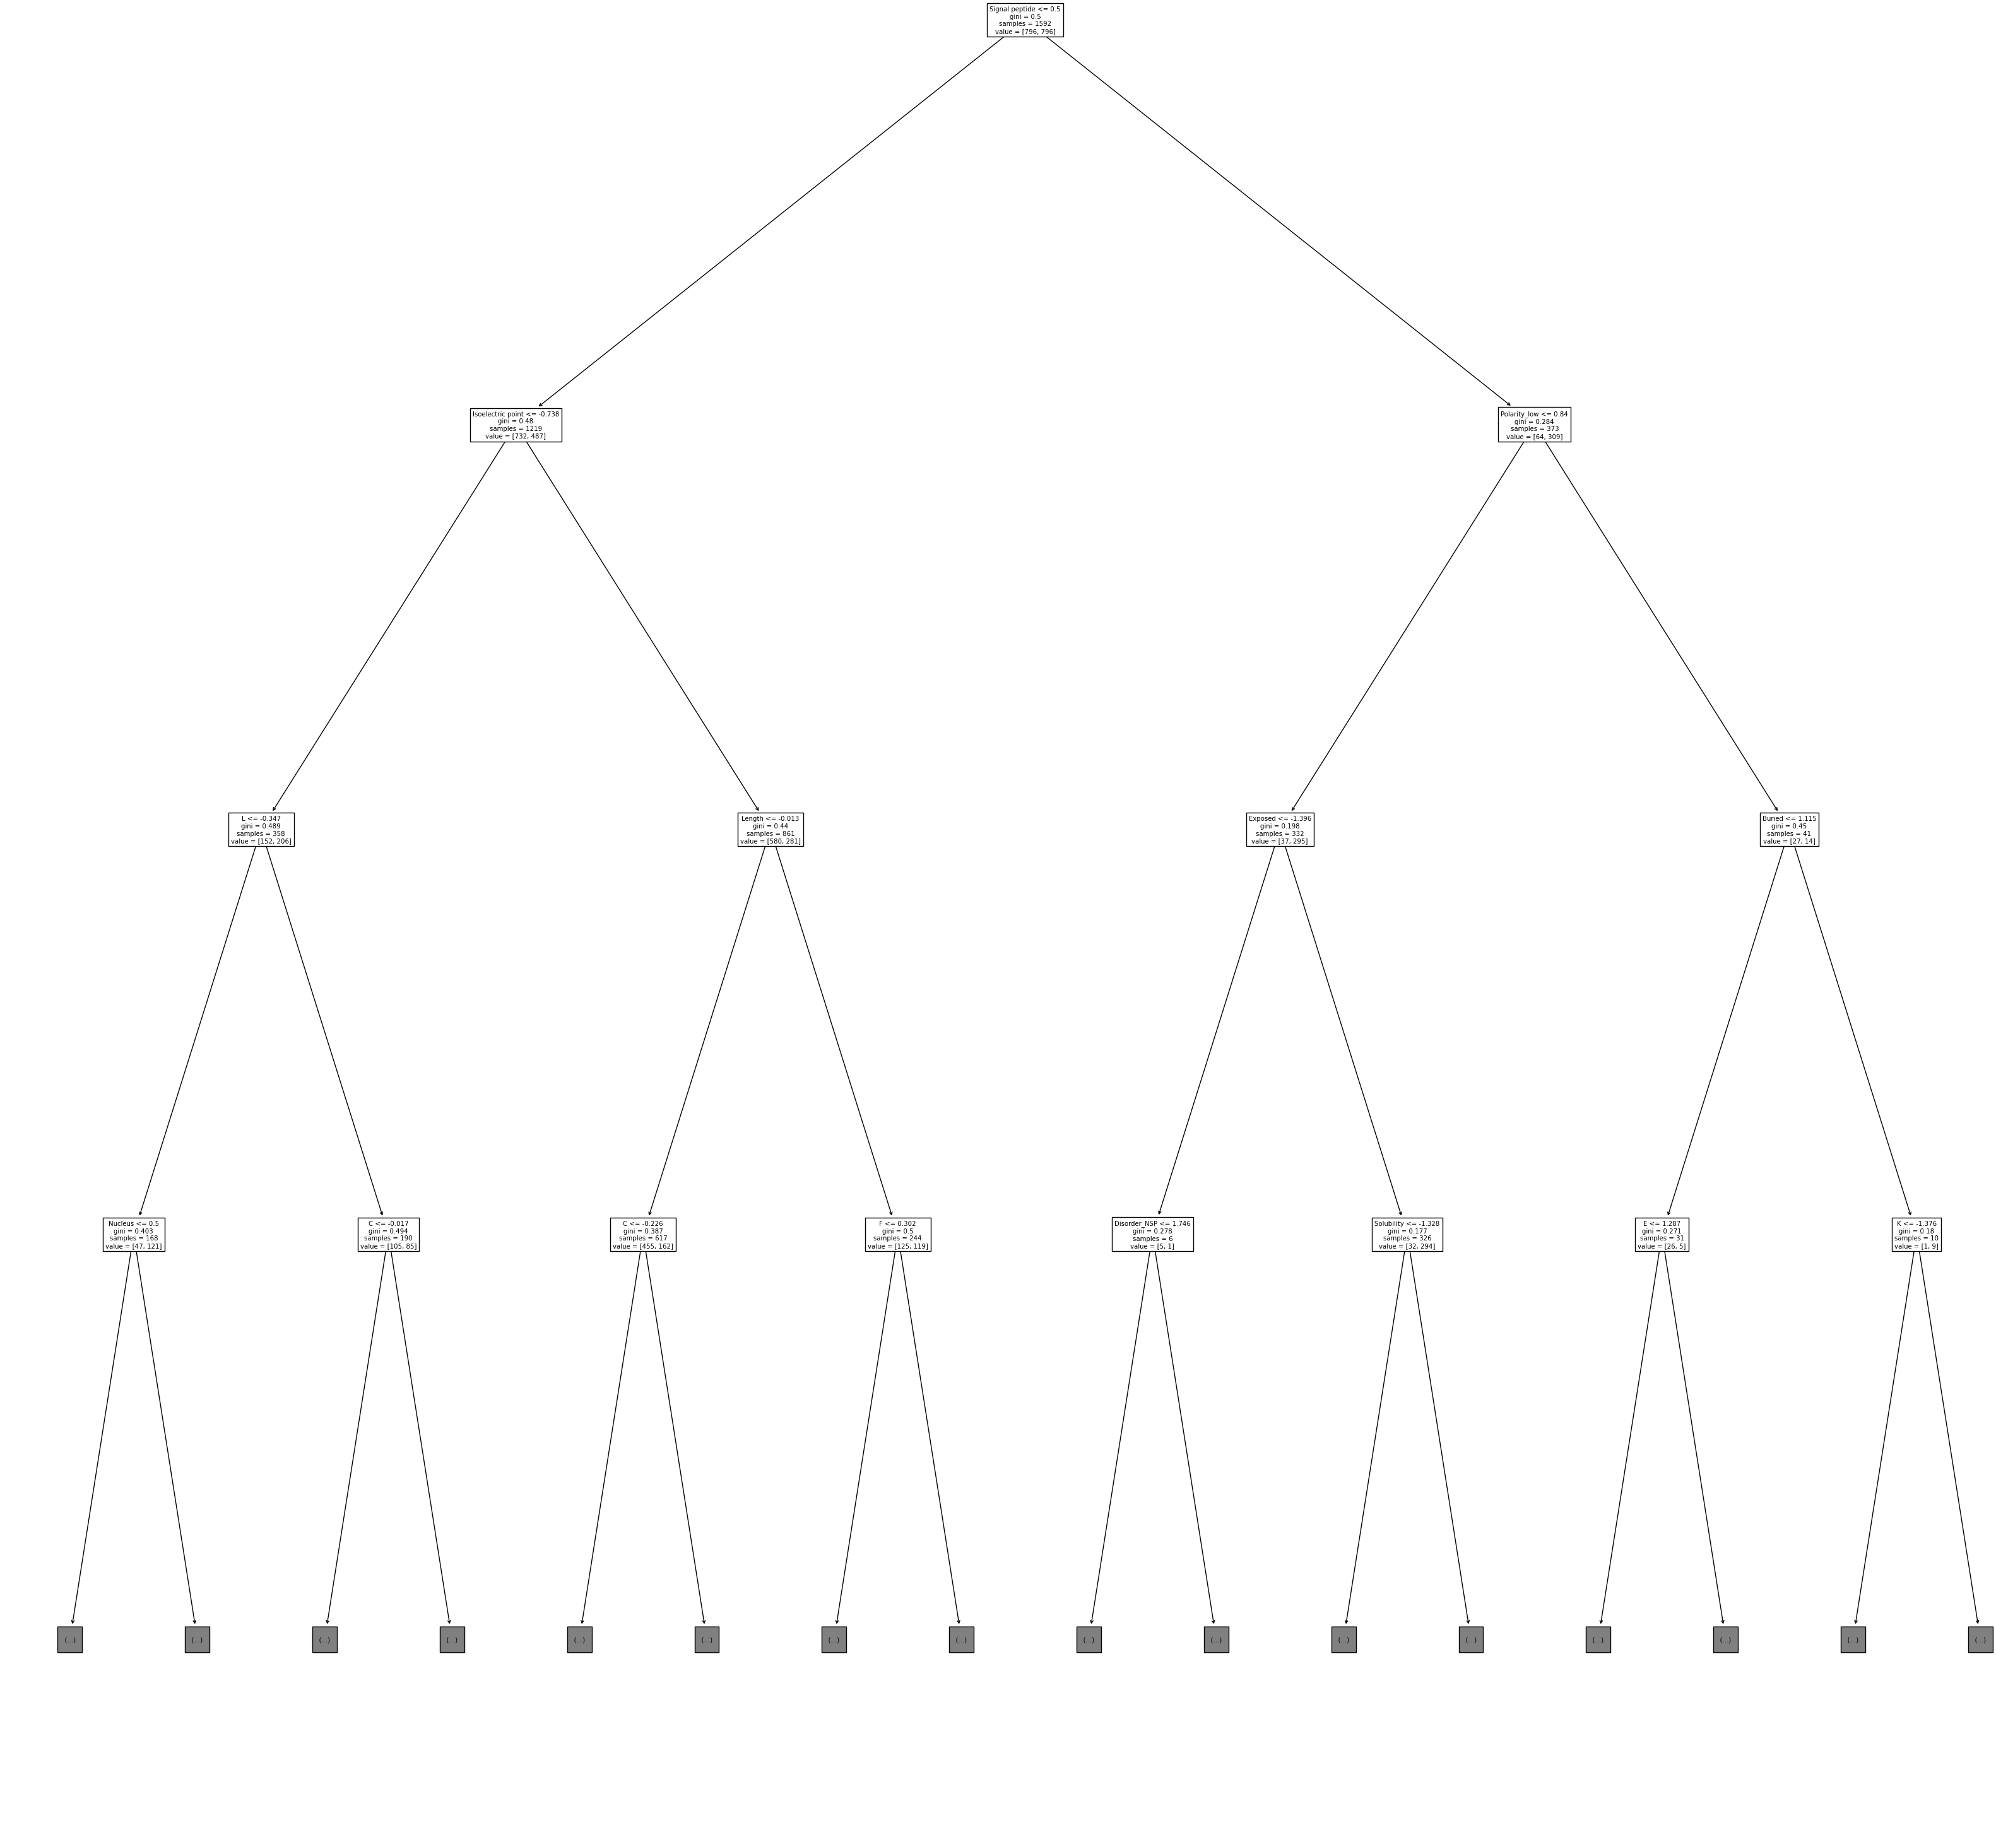

In [28]:
fig, ax = plt.subplots(figsize=(30,30))

plot_tree(dt, max_depth=3, feature_names=X_train_bal.columns)
plt.show()